## Setup and Configuration for Data Analysis

### Libraries and Packages
- **Pandas**: For data manipulation and analysis.
- **Matplotlib** and **Seaborn**: For data visualization.
- **Glob** and **OS**: For file operations across operating systems.
- **re**: For regular expression operations.
- **NumPy**: For numerical operations on arrays.
- **scikit-learn**: Specifically, `GroupShuffleSplit` for generating training/testing sets.
- **shutil** and **cv2**: For operations related to file management and image processing.
- **Pathlib**: For easy manipulation of file paths.

### Configuration
- **Pandas Display Options**: Configured to ensure that the display of dataframes in this notebook is not truncated, facilitating the exploration of datasets with many rows or columns.

In [151]:
# Packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import re
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from shutil import copyfile
import cv2
from pathlib import Path
from shutil import rmtree
import importlib

import sys
import os


# Set display options
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None) 

In [152]:
# Construct the absolute path to the 'lib' directory based on your current working directory
current_dir = os.getcwd()  # Get the current working directory
lib_path = os.path.abspath(os.path.join(current_dir, 'lib'))  # Go up one level and then access the 'lib' directory

# Add the 'lib' directory to sys.path if it's not already there
if lib_path not in sys.path:
    sys.path.append(lib_path)

import prep_images as pi

import importlib
import prep_images
importlib.reload(prep_images)


print(dir(prep_images))  # Check again

['Path', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__warningregistry__', 'check_for_overlap', 'convert_column_to_string', 'crop_and_resize_image', 'cv2', 'extract_image_labels', 'extract_patient_codes', 'find_image_border', 'glob', 'missing_counts', 'np', 'os', 'pd', 'preprocess_us_number', 'process_images_and_create_csv', 'process_images_in_directory', 're', 'rename_files_in_directory', 'rmtree', 'test_split', 'write_records_to_csv']


In [153]:
# Relative path to the CSV file
relative_path = '../2. Data and Description/data.csv'

# Read the CSV file
df = pd.read_csv(relative_path, delimiter=";")

## Configuration of Constants and Directory Setup

This section defines essential constants and directory paths used throughout the notebook for managing and processing ultrasound images:

- **Directories**: Sets up paths for raw and processed images, categorized into training, test, and other specific uses.
- **Image Processing Parameters**: Configures the type of padding for images and identifies the target variable for prediction tasks.
- **Features**: Lists specific tabular features and categorizes them into continuously valued and binary valued for structured processing.
- **Directory Initialization**: Ensures all specified directories exist, creating them if necessary to prevent runtime errors when saving files.

In [154]:
# Important constants

# Directories
# Directory with the original, unprocessed ultrasound images
IMAGE_DIR = 'USPictures'
# Directory for saving unprocessed ultrasound images from the training set
TRAIN_IMAGE_DIR = 'USPictures/Train'
# Directory for saving unprocessed ultrasound images from the test set
TEST_IMAGE_DIR = 'USPictures/Test'
# Directory for preprocessed images
TRAIN_IMAGE_PREP_DIR = TRAIN_IMAGE_DIR + "/Processed"
TEST_IMAGE_PREP_DIR = TEST_IMAGE_DIR + "/Processed"
# Directory for the temporary output of the DeepFill model
DEPFILL_TEMP_DIR = 'USPictures/Deepfill'
# Excel file with the tabular data
CLINICAL_DATA_FILE = df
# Directory for saving the data dictionaries
OUTPUT_DIR = 'Output'
# File with the names of the images containing multiple US snapshots
BLACKLIST_FILE = 'multiple_in_one_'



# Directory Initialization
# Create directories if they do not exist
if not os.path.exists(TRAIN_IMAGE_DIR):
    os.makedirs(TRAIN_IMAGE_DIR)
if not os.path.exists(TEST_IMAGE_DIR):
    os.makedirs(TEST_IMAGE_DIR)

## Collecting and Analyzing Ultrasound Image Data

This script processes a directory of ultrasound images to gather insights into the dataset's composition regarding both the number of images and the distinct patients represented.

### Key Steps:

- **Path Aggregation**: Gathers all image file paths with `.png` and `.bmp` extensions from the specified `IMAGE_DIR`.
- **Patient Code Extraction**: For each image file, the script extracts a presumed patient code, which is the initial segment of the filename. This segment is expected to be a unique identifier for patients.
- **Analysis Outputs**:
  - Displays the total number of unique patients, which helps in understanding the dataset's diversity and patient coverage.
  - Shows the total count of images, providing a basic metric of the dataset size.


In [155]:
# Assuming IMAGE_DIR is set to 'USPictures' which is relative to your current working directory
image_file_list = glob.glob(os.path.join(IMAGE_DIR, '*.png')) + glob.glob(os.path.join(IMAGE_DIR, '*.bmp'))

image_names = []
groups = []

for file in image_file_list:
    # Extract just the name of the file, without the preceding directory path
    name = os.path.basename(file)
    # Now split the name to extract the patient code
    patient_code = re.split('_| |\.', name)[0]
    groups.append(patient_code)

roups = np.array(list(map(int, groups)))
print("Total number of patients having US images: ", len(np.unique(groups)))
print("Total number of images: ", len(image_file_list))


Total number of patients having US images:  707
Total number of images:  2095


## Splitting Image Data into Training and Test Sets

This section of the notebook handles the division of ultrasound image files into training and test sets based on the patient codes to ensure data integrity and prevent leakage between these sets.

### Procedure:

- **List of Image Names**: Extracts just the filenames from the full paths, simplifying file handling in subsequent steps.
- **Group Shuffle Split**:
  - Utilizes `GroupShuffleSplit` to split image files into groups based on patient codes, maintaining approximately 90% of the data for training and 10% for testing. This ensures that all images from a single patient are in the same set.
  - The split is controlled by a fixed random state to allow reproducibility of the results.
- **File Copying**:
  - Iterates over each image, and based on its determined index from the shuffle split, copies it to the appropriate directory (`TRAIN_IMAGE_DIR` for training and `TEST_IMAGE_DIR` for testing).
  - Handles both `.png` and `.bmp` file formats, covering all the image data types present in the dataset.


In [156]:
# Populate image_names with just the file names
image_names = [os.path.basename(file) for file in image_file_list]

gss = GroupShuffleSplit(n_splits=1, train_size=.9, random_state=42)
for idx1, idx2 in gss.split(image_names, groups=groups):
    train_idx = idx1
    test_idx = idx2


for image_idx, image_name in enumerate(image_names):
    # Check if the image file is PNG or BMP
    if image_name.endswith('.png') or image_name.endswith('.bmp'):
        if image_idx in train_idx:
            copyfile(os.path.join(IMAGE_DIR, image_name), os.path.join(TRAIN_IMAGE_DIR, image_name))
        else:
            copyfile(os.path.join(IMAGE_DIR, image_name), os.path.join(TEST_IMAGE_DIR, image_name))

In [157]:
# Verify that patients in the splits do not overlap
pi.test_split(TRAIN_IMAGE_DIR, TEST_IMAGE_DIR)


Number of patients in train set:  636
Number of patients in test set:  71

Number of images in train set:  1907
Number of images in test set:  188

Patients in train and test set don't overlap!


In [158]:
# Directories to process
directories = [TRAIN_IMAGE_DIR, TEST_IMAGE_DIR]

# Apply the renaming function to each directory
for directory in directories:
    pi.rename_files_in_directory(directory)

File renaming complete in USPictures/Train.
File renaming complete in USPictures/Test.


In [159]:
os.listdir(TRAIN_IMAGE_DIR)

['1.1 RLQ_Pathological Lymphnodes.png',
 '1.2 Ileitis.png',
 '1.3 Mesenterial Lymphadenitis.png',
 '1.4 Appendix.png',
 '1.4_Appendix.png.png',
 '1.5 Appendix, surrounding tissue reaction.png',
 '10.1 Appendix and surrounding free fluis.png',
 '10.2 Appendix and surrounding free fluis.png',
 '100.1_App_M.png',
 '100.2_RLQ.png',
 '100.3_RLQ.png',
 '101.10_App_M.png',
 '101.11_App_M.png',
 '101.12_App.png',
 '101.13_App_M.png',
 '101.14_App.png',
 '101.15_App.png',
 '101.1_App_M.png',
 '101.2_App_D.png',
 '101.3_App_M.png',
 '101.4_App_M.png',
 '101.5_App_M.png',
 '101.6_App_M.png',
 '101.7_App_M.png',
 '101.8_App.png',
 '101.9_App_M.png',
 '102.10_App.png',
 '102.11.png',
 '102.12_App.png',
 '102.13_App_M.png',
 '102.14_App.png',
 '102.15_App_M.png',
 '102.16_App_M.png',
 '102.17_App_M.png',
 '102.18_App.png',
 '102.19_App.png',
 '102.1_App.png',
 '102.2_App.png',
 '102.3_App.png',
 '102.4_App.png',
 '102.5_App_M.png',
 '102.6_App.png',
 '102.7_App.png',
 '102.8_App.png',
 '102.9_App.pn

## Image Preprocessing for Appendicitis Ultrasound Images

This script is designed to automate the preprocessing of ultrasound images of appendicitis. The main goals are to identify and crop the relevant part of each image and to resize it to a standard dimension. This standardization is crucial for consistent analysis in subsequent processing steps such as feature extraction or machine learning modeling.

### Set Thresholds and Target Dimensions: 
   - `FOREGROUND_THRESHOLD`: This determines the minimum percentage of foreground pixels (pixels above a certain intensity) required for a row to be considered as containing relevant content.
   - `SHADE_THRESHOLD`: This is the intensity above which a pixel is considered part of the foreground.
   - `TARGET_DIMS`: The dimensions to which all images will be resized after cropping.

In [160]:
# Constants
FOREGROUND_THRESHOLD = 0.2
SHADE_THRESHOLD = 6
TARGET_DIMS = (400, 400)


# Directories to process
prep_images.process_images_in_directory(TRAIN_IMAGE_DIR, TRAIN_IMAGE_PREP_DIR, FOREGROUND_THRESHOLD, SHADE_THRESHOLD, TARGET_DIMS)
prep_images.process_images_in_directory(TEST_IMAGE_DIR, TEST_IMAGE_PREP_DIR, FOREGROUND_THRESHOLD, SHADE_THRESHOLD, TARGET_DIMS)

Processed images are saved in USPictures/Train/Processed
Processed images are saved in USPictures/Test/Processed


In [161]:
CLINICAL_DATA_FILE = prep_images.preprocess_us_number(CLINICAL_DATA_FILE)
CLINICAL_DATA_FILE = prep_images.convert_column_to_string(CLINICAL_DATA_FILE, 'US_Number')

c:\Users\Benedict\Desktop\Business Analytics and Econometrics\SS24\Seminar\MLSEM\7. US_Pictures\lib\prep_images.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[us_number_col] = df[us_number_col].astype(int)
c:\Users\Benedict\Desktop\Business Analytics and Econometrics\SS24\Seminar\MLSEM\7. US_Pictures\lib\prep_images.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df[column_name].astype(str)


In [162]:
CLINICAL_DATA_FILE.loc[CLINICAL_DATA_FILE['US_Number'] == '662']

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Management,Severity,Diagnosis_Presumptive,Diagnosis,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_on_US,Appendix_Diameter,Migratory_Pain,Lower_Right_Abd_Pain,Contralateral_Rebound_Tenderness,Coughing_Pain,Nausea,Loss_of_Appetite,Body_Temperature,WBC_Count,Neutrophil_Percentage,Segmented_Neutrophils,Neutrophilia,RBC_Count,Hemoglobin,RDW,Thrombocyte_Count,Ketones_in_Urine,RBC_in_Urine,WBC_in_Urine,CRP,Dysuria,Stool,Peritonitis,Psoas_Sign,Ipsilateral_Rebound_Tenderness,US_Performed,US_Number,Free_Fluids,Appendix_Wall_Layers,Target_Sign,Appendicolith,Perfusion,Perforation,Surrounding_Tissue_Reaction,Appendicular_Abscess,Abscess_Location,Pathological_Lymph_Nodes,Lymph_Nodes_Location,Bowel_Wall_Thickening,Conglomerate_of_Bowel_Loops,Ileus,Coprostasis,Meteorism,Enteritis,Gynecological_Findings,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68


In [164]:
prep_images.process_images_and_create_csv(TRAIN_IMAGE_PREP_DIR, CLINICAL_DATA_FILE)
prep_images.process_images_and_create_csv(TEST_IMAGE_PREP_DIR, CLINICAL_DATA_FILE)
print(f"Missing US_Number entries in TRAIN: {prep_images.missing_counts['train']}")
print(f"Missing US_Number entries in TEST: {prep_images.missing_counts['test']}")

US_Number 102 not found in DataFrame.
US_Number 102 not found in DataFrame.
US_Number 102 not found in DataFrame.
US_Number 102 not found in DataFrame.
US_Number 102 not found in DataFrame.
US_Number 102 not found in DataFrame.
US_Number 102 not found in DataFrame.
US_Number 102 not found in DataFrame.
US_Number 102 not found in DataFrame.
US_Number 102 not found in DataFrame.
US_Number 102 not found in DataFrame.
US_Number 102 not found in DataFrame.
US_Number 102 not found in DataFrame.
US_Number 102 not found in DataFrame.
US_Number 102 not found in DataFrame.
US_Number 102 not found in DataFrame.
US_Number 102 not found in DataFrame.
US_Number 102 not found in DataFrame.
US_Number 102 not found in DataFrame.
US_Number 22 not found in DataFrame.
US_Number 22 not found in DataFrame.
US_Number 22 not found in DataFrame.
US_Number 22 not found in DataFrame.
US_Number 22 not found in DataFrame.
US_Number 23 not found in DataFrame.
US_Number 23 not found in DataFrame.
US_Number 230 not f

# CNN

#### Multview Approach,  still on Progress

In [282]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from pathlib import Path
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import cv2

def preprocess_image(image_array):
    if image_array.ndim == 3 and image_array.shape[2] == 3:
        image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
    elif image_array.ndim == 3 and image_array.shape[2] == 4:
        image_array = cv2.cvtColor(image_array, cv2.COLOR_BGRA2GRAY)
    if image_array.dtype != np.uint8:
        image_array = (255 * image_array).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image_array = clahe.apply(image_array)
    image_array = cv2.medianBlur(image_array, 5)
    return image_array.astype(np.float32) / 255.0

def extract_patient_id(filename):
    return filename.split('.')[0]

def load_data(image_dir, label_file, target_size=(128, 128), max_sequence_length=15):
    df = pd.read_csv(label_file, header=None, names=['filename', 'label', 'complication', 'treatment'])
    df['patient_id'] = df['filename'].apply(lambda filename: filename.split('.')[0])  # Extract patient ID from filename

    grouped = df.groupby('patient_id')

    sequences = []
    labels = []
    all_filenames = []  # To store filenames for each sequence for the DataFrame

    for patient_id, group in grouped:
        images = []
        filenames = []  # To track filenames for the current sequence
        for idx, row in group.iterrows():
            img_path = Path(image_dir) / row['filename']
            if img_path.exists():
                img = tf.keras.preprocessing.image.load_img(img_path, color_mode='rgb', target_size=target_size)
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                processed_image = preprocess_image(img_array)
                processed_image = np.expand_dims(processed_image, axis=-1)  # Ensure image has channel dimension
                if processed_image is not None:
                    images.append(processed_image)
                    filenames.append(row['filename'])  # Track filename

        if images:
            # Pad or truncate the list of images to ensure consistent length
            images = images[:max_sequence_length]  # Truncate if longer
            if len(images) < max_sequence_length:
                # Pad with zero arrays if shorter
                padding = [np.zeros((target_size[0], target_size[1], 1)) for _ in range(max_sequence_length - len(images))]
                images.extend(padding)
                filenames.extend([''] * (max_sequence_length - len(filenames)))  # Pad filenames with empty strings

            sequences.append(np.stack(images))  # Stack images to create a single array per patient
            labels.append(group['label'].iloc[0])  # Assume all images per patient have the same label
            all_filenames.append(filenames)  # Append list of filenames for this sequence

    # Convert labels to one-hot encoding
    labels = pd.get_dummies(labels).values

    # Create DataFrame to track filenames and labels
    data_df = pd.DataFrame({
        'Filename': [item for sublist in all_filenames for item in sublist],  # Flatten list of filenames
        'Label': np.repeat(labels.argmax(axis=1), max_sequence_length)  # Repeat labels for each image in sequence
    })

    return np.array(sequences), labels, data_df

# Example usage
train_images, train_labels, train_df = load_data(TRAIN_IMAGE_DIR, 'image_labels.csv')
test_images, test_labels, test_df = load_data(TEST_IMAGE_DIR, 'image_labels.csv')

In [283]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

def create_3d_cnn_model(input_shape, num_classes):
    model = models.Sequential()
    
    # 3D Convolutional layers
    model.add(layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(layers.Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

    # Flatten and Dense layers to perform final classification
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Assuming that `train_images` and `test_images` have the shape [samples, sequence_length, width, height, channels]
# If train_images are not in the correct shape, you will need to reshape them accordingly
input_shape = train_images.shape[1:]  # This assumes train_images is already in the correct shape
num_classes = train_labels.shape[1]  # Assuming train_labels are one-hot encoded

model = create_3d_cnn_model(input_shape, num_classes)



C:\Users\Benedict\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [284]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(
    train_images, train_labels,
    validation_split=0.2,  # Using part of the training data as validation
    epochs=100,
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc}")

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - accuracy: 0.5957 - loss: 24.2836 - val_accuracy: 0.7404 - val_loss: 0.7671
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.5795 - loss: 9.0237 - val_accuracy: 0.5673 - val_loss: 2.7584
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - accuracy: 0.6916 - loss: 5.0448 - val_accuracy: 0.5192 - val_loss: 2.5208
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - accuracy: 0.6616 - loss: 2.5892 - val_accuracy: 0.4519 - val_loss: 3.8010
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.5713 - loss: 1.0964 - val_accuracy: 0.5096 - val_loss: 3.2618
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - accuracy: 0.6858 - loss: 0.7722 - val_accuracy: 0.5577 - val_loss: 2.0127
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - accuracy: 0.5784 - loss: 0.7575 - val_accuracy: 0.5962 - val_loss: 2.5166
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - accuracy: 0.6857 - loss: 0.6443 - val_accuracy: 0.6058 - 

In [299]:
def predict_and_evaluate_individual_images(model, test_images, test_labels, test_df):
    # Ensure predictions are made on properly formatted data
    predicted_classes = model.predict(test_images)
    predicted_labels = np.argmax(predicted_classes, axis=-1)

    filenames = []
    actual_labels = []

    # Iterate through each sequence in test_images
    for i, (images, label) in enumerate(zip(test_images, test_labels)):
        # Retrieve the corresponding patient data from test_df
        patient_data = test_df.iloc[i]
        sequence_filenames = patient_data['Filename'].split(',')

        # Extend the filenames list with the filenames for this patient
        filenames.extend(sequence_filenames)

        # Extend actual_labels with the actual label repeated for each image in the sequence
        actual_label = patient_data['Label']
        actual_labels.extend([actual_label] * len(sequence_filenames))

        # Check for data consistency
        if len(sequence_filenames) != images.shape[0]:
            print(f"Data mismatch for index {i}: Number of filenames does not match number of images.")
            continue

    # Ensure that the number of predicted labels matches the number of filenames
    if len(filenames) != len(predicted_labels):
        raise ValueError("Mismatch in the number of filenames and number of predicted labels.")

    # Map predicted indices back to labels if necessary
    mapped_predicted_labels = [test_df['Label'].unique()[pred] for pred in predicted_labels]

    # Create a DataFrame to compare actual vs. predicted
    results_df = pd.DataFrame({
        'Filename': filenames,
        'Actual Label': actual_labels,
        'Predicted Label': mapped_predicted_labels
    })

    return results_df

# Example usage assuming the model is already trained and available
results_df = predict_and_evaluate_individual_images(model, test_images, test_labels, test_df)
print(results_df.head())

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
Data mismatch for index 0: Number of filenames does not match number of images.
Data mismatch for index 1: Number of filenames does not match number of images.
Data mismatch for index 2: Number of filenames does not match number of images.
Data mismatch for index 3: Number of filenames does not match number of images.
Data mismatch for index 4: Number of filenames does not match number of images.
Data mismatch for index 5: Number of filenames does not match number of images.
Data mismatch for index 6: Number of filenames does not match number of images.
Data mismatch for index 7: Number of filenames does not match number of images.
Data mismatch for index 8: Number of filenames does not match number of images.
Data mismatch for index 9: Number of filenames does not match number of images.
Data mismatch for index 10: Number of filenames does not match number of images.
Data mismatch for index 11: Number of filenames does not match number of images.

In [300]:
results_df

,Filename,Actual Label,Predicted Label
0,108.1_App_M.png,0,1
1,108.2_App_M.png,0,0
2,,0,1
3,,0,0
4,,0,0
5,,0,1
6,,0,1
7,,0,0
8,,0,0
9,,0,0


#### Each image on its own

## Load and Preprocess the Data

### Without Image Editing

#### Loading

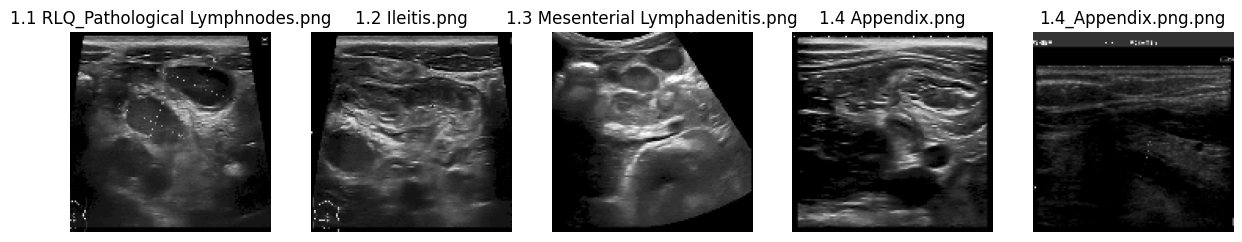

In [187]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

def plot_images(images, titles, num_images=5):
    """Plot a sample of images, ensuring they are correctly scaled for display."""
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, ax in enumerate(axes):
        img = images[i]
        # Normalize float images to the range [0, 1] if needed
        if img.dtype == np.float32 or img.dtype == np.float64:
            img = (img - img.min()) / (img.max() - img.min())
        ax.imshow(img, cmap='gray')  # Use cmap='gray' if images are grayscale
        ax.set_title(titles[i])
        ax.axis('off')
    plt.show()

def load_data(image_dir, label_file, target_size=(128, 128), show_examples=False, num_images=5):
    df = pd.read_csv(label_file)
    df = df[df['filename'].str.contains('.png')]
    df['path'] = df['filename'].apply(lambda x: Path(image_dir) / x)
    df = df[df['path'].apply(Path.exists)]

    images = []
    labels = []
    file_names = []
    for _, row in df.iterrows():
        try:
            img = tf.keras.preprocessing.image.load_img(row['path'], color_mode='rgb', target_size=target_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            images.append(img_array)
            labels.append(row['label'])
            file_names.append(row['filename'])
        except Exception as e:
            print(f"Error loading {row['path']}: {e}")

    if not images:
        print("No valid images were loaded.")
        return None, None, None

    images = np.array(images)
    labels = pd.get_dummies(labels).values
    if show_examples:
        plot_images(images[:num_images], file_names[:num_images], num_images=min(num_images, len(images)))  # Display examples

    return images, labels, pd.DataFrame({'Filename': file_names, 'Label': labels.argmax(axis=1)})

# Example usage
train_images, train_labels, train_df = load_data(TRAIN_IMAGE_PREP_DIR, 'image_labels.csv', show_examples=True)

#### Architecture

In [259]:
# Self created 

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def create_advanced_cnn_model(num_classes):
    model = models.Sequential([
        layers.Input(shape=(128, 128, 1)),  # Ensure the input shape matches your data
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),  # Dropout to prevent overfitting
        layers.Dense(num_classes, activation='softmax')  # Softmax for multiclass classification
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Assuming 'train_labels' and 'test_labels' are already in one-hot encoded form
num_classes = train_labels.shape[1]  # Adjust based on your actual setup
model = create_advanced_cnn_model(num_classes)



##### ResNet

In [209]:
# Resnet
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

def create_resnet_model(num_classes, input_shape=(128, 128, 1)):
    base_model = ResNet50(include_top=False, weights=None, input_shape=input_shape)

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Usage
num_classes = train_labels.shape[1]  # Adjust based on your actual setup
model_resnet = create_resnet_model(num_classes)


##### GooLeNet

In [233]:
# Googlenet

from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout, Input
from tensorflow.keras.models import Model

def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    path1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

    path2 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    path2 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(path2)

    path3 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    path3 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(path3)

    path4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(path4)

    return layers.concatenate([path1, path2, path3, path4], axis=-1)

def create_googlenet_model(num_classes, input_shape=(128, 128, 1)):
    input_layer = Input(shape=input_shape)
    
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, 64, 96, 128, 16, 32, 32)
    x = inception_module(x, 128, 128, 192, 32, 96, 64)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, 192, 96, 208, 16, 48, 64)
    x = inception_module(x, 160, 112, 224, 24, 64, 64)

    x = AveragePooling2D((4, 4), strides=(1, 1))(x)  # Reduced pooling window
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=predictions)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Usage
num_classes = train_labels.shape[1]  # Adjust based on your actual setup
model_googlenet = create_googlenet_model(num_classes)


#### Training Process

In [263]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

model = model # for other architecture model_googlenet or model_resnet

# Adjust the learning rate directly in the optimizer
optimizer = Adam(learning_rate=0.00001)

# Callbacks to enhance training
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(
    train_images, train_labels, 
    validation_split=0.2,  # Assuming you want to use a fraction of training data for validation
    epochs=100,
    callbacks=[early_stopping],
    class_weight=class_weights  # Assuming class_weights are defined
)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.6118 - loss: 1.9086 - val_accuracy: 0.3974 - val_loss: 6.4194
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.6237 - loss: 2.0839 - val_accuracy: 0.4199 - val_loss: 1.4258
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.5767 - loss: 1.2179 - val_accuracy: 0.2756 - val_loss: 4.2641
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.5495 - loss: 1.4953 - val_accuracy: 0.6603 - val_loss: 4.4823
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.7049 - loss: 1.9574 - val_accuracy: 0.6699 - val_loss: 2.4846
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.6714 - loss: 2.6617 - val_accuracy: 0.2468 - val_loss: 22.1463
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.5768 - loss: 3.4083 - val_accuracy: 0.3942 - val_loss: 3.9756
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.5899 - loss: 3.2118 - val_accuracy: 0.2468 - 

#### Evaluation

In [265]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - accuracy: 0.7600 - loss: 0.7351
Test Accuracy: 0.7108433842658997


#### Show Predicted and True Labels

In [269]:
# Assuming 'test_images' have been loaded and 'model' has been defined and trained
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Assuming test_labels are one-hot encoded, we get the actual class indices
actual_classes = np.argmax(test_labels, axis=1)

# Load the label file to get filenames and corresponding labels
df_test = pd.read_csv('image_labels.csv')
df_test = df_test[df_test['filename'].apply(lambda x: Path(TEST_IMAGE_PREP_DIR) / x).apply(Path.exists)]

# Ensure the DataFrame only includes files used in the test dataset
df_test = df_test[df_test['filename'].isin([f.name for f in Path(TEST_IMAGE_PREP_DIR).glob('*.png')])]

# Assuming there's an established mapping of indices to label names
labels_mapping = pd.get_dummies(df_test['label']).columns  # This assumes the original DataFrame has correct labels

predicted_labels = [labels_mapping[pred] for pred in predicted_classes]

# Create a DataFrame to compare actual vs. predicted
results_df = pd.DataFrame({
    'Filename': df_test['filename'].tolist(),
    'Actual Label': [labels_mapping[act] for act in actual_classes],
    'Predicted Label': predicted_labels
})

# Print the DataFrame
results_df

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 319ms/step


,Filename,Actual Label,Predicted Label
0,108.1_App_M.png,appendicitis,no appendicitis
1,108.2_App_M.png,appendicitis,no appendicitis
2,168.1_App_M.png,appendicitis,appendicitis
3,168.2_App.png,appendicitis,appendicitis
4,168.3_App.png,appendicitis,no appendicitis
5,168.4_App_M.png,appendicitis,appendicitis
6,168.5_App.png,appendicitis,appendicitis
7,168.6_App.png,appendicitis,appendicitis
8,168.7_App.png,appendicitis,no appendicitis
9,168.8_App.png,appendicitis,no appendicitis


### With Image Editing

#### Loading and Preprocessing

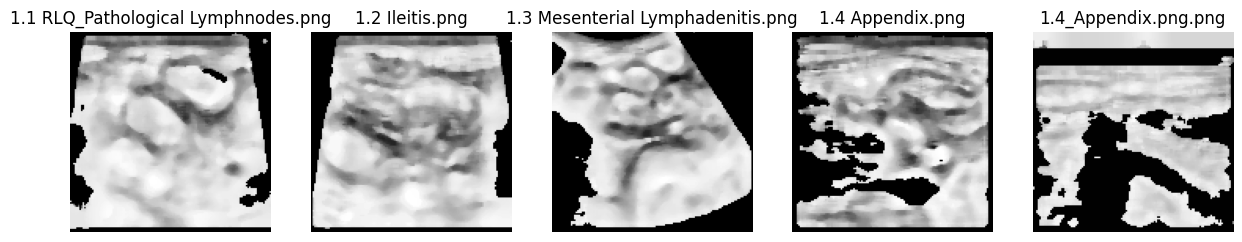

{0: 0.6400986031224322, 1: 2.2844574780058653}


In [216]:
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import cv2

def preprocess_image(image_array):
    try:
        # Convert to grayscale if necessary
        if image_array.ndim == 3 and image_array.shape[2] == 3:
            image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
        elif image_array.ndim == 3 and image_array.shape[2] == 4:
            image_array = cv2.cvtColor(image_array, cv2.COLOR_BGRA2GRAY)

        # Convert to 8-bit if necessary
        if image_array.dtype != np.uint8:
            image_array = (255 * image_array).astype(np.uint8)

        # Apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        image_array = clahe.apply(image_array)

        # Apply Median Filtering
        image_array = cv2.medianBlur(image_array, 5)

        # Normalize the image
        image_array = image_array.astype(np.float32) / 255.0
    except Exception as e:
        print(f"Error during preprocessing: {e}")
        return None

    return image_array

def plot_images(images, titles, num_images=5):
    """Plot a sample of preprocessed images."""
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i].squeeze(), cmap='gray')
            ax.set_title(titles[i])
            ax.axis('off')
    plt.show()

def load_data(image_dir, label_file, target_size=(128, 128), show_examples=False,  num_images=5):
    df = pd.read_csv(label_file)
    df = df[df['filename'].str.contains('.png')]
    df['path'] = df['filename'].apply(lambda x: Path(image_dir) / x)
    df = df[df['path'].apply(Path.exists)]

    images = []
    labels = []
    file_names = []
    for _, row in df.iterrows():
        try:
            img = tf.keras.preprocessing.image.load_img(row['path'], color_mode='rgb', target_size=target_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            processed_image = preprocess_image(img_array)
            if processed_image is not None:
                images.append(np.expand_dims(processed_image, axis=-1))
                labels.append(row['label'])
                file_names.append(row['filename'])
        except Exception as e:
            print(f"Error loading {row['path']}: {e}")

    if not images:
        print("No valid images were loaded.")
        return None, None, None

    images = np.array(images)
    labels = pd.get_dummies(labels).values

    if show_examples:
        plot_images(images[:min(num_images, len(images))], file_names[:min(num_images, len(images))], min(num_images, len(images)))

    return images, labels, pd.DataFrame({'Filename': file_names, 'Label': labels.argmax(axis=1)})

# Example usage
train_images, train_labels, train_df = load_data(TRAIN_IMAGE_PREP_DIR, 'image_labels.csv', show_examples=True)
test_images, test_labels, test_df = load_data(TEST_IMAGE_PREP_DIR, 'image_labels.csv')

if train_images is not None and train_labels is not None:
    # Calculate class weights
    def get_class_weights(y):
        classes = np.unique(y)
        weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
        class_weights_dict = dict(zip(classes, weights))
        return class_weights_dict

    train_labels_argmax = train_df['Label'].values  # Ensure this is a 1D array of your labels
    class_weights = get_class_weights(train_labels_argmax)
    print(class_weights)
else:
    print("No valid images were loaded.")

#### Architecture

In [202]:
from tensorflow.keras import layers, models

def create_advanced_cnn_model(num_classes):
    model = models.Sequential([
        layers.Input(shape=(128, 128, 1)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Now use the advanced model in your training setup
model = create_advanced_cnn_model(train_labels.shape[1])

#### Training Process

In [217]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
history = model_resnet.fit(
    train_images, train_labels, 
    validation_data=(test_images, test_labels),
    epochs=100,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.5026 - loss: 0.6513 - val_accuracy: 0.7711 - val_loss: 0.6218 - learning_rate: 1.0000e-05
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.5451 - loss: 0.6641 - val_accuracy: 0.7711 - val_loss: 0.6119 - learning_rate: 1.0000e-05
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.5585 - loss: 0.6148 - val_accuracy: 0.7711 - val_loss: 0.6073 - learning_rate: 1.0000e-05
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.6043 - loss: 0.5823 - val_accuracy: 0.7711 - val_loss: 0.6070 - learning_rate: 1.0000e-05
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.6305 - loss: 0.5859 - val_accuracy: 0.7651 - val_loss: 0.6053 - learning_rate: 1.0000e-05
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.6979 - loss: 0.5564 - val_accuracy: 0.7410 - val_loss: 0.6120 - learning_rate: 1.0000e-05
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7316 

#### Evaluation

In [218]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)

print(f"Test Accuracy: {test_acc}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.4827 - loss: 0.6677
Test Accuracy: 0.5060241222381592


#### Show predicted and true Labels

In [219]:
# Assuming 'test_images' have been loaded and 'model' has been defined and trained
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Assuming test_labels are one-hot encoded, we get the actual class indices
actual_classes = np.argmax(test_labels, axis=1)

# Load the label file to get filenames and corresponding labels
df_test = pd.read_csv('image_labels.csv')
df_test = df_test[df_test['filename'].apply(lambda x: Path(TEST_IMAGE_PREP_DIR) / x).apply(Path.exists)]

# Ensure the DataFrame only includes files used in the test dataset
df_test = df_test[df_test['filename'].isin([f.name for f in Path(TEST_IMAGE_PREP_DIR).glob('*.png')])]

# Map indices back to actual labels
# Assuming you have a label encoding mechanism or the labels are already named in 'df_test'
labels_mapping = pd.get_dummies(df_test['label']).columns  # This extracts label names from one-hot encoding

predicted_labels = [labels_mapping[pred] for pred in predicted_classes]

# Create a DataFrame to compare actual vs. predicted
results_df = pd.DataFrame({
    'Filename': df_test['filename'],
    'Actual Label': [labels_mapping[act] for act in actual_classes],
    'Predicted Label': predicted_labels
})

# Print the DataFrame
results_df

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step


,Filename,Actual Label,Predicted Label
1558,108.1_App_M.png,appendicitis,appendicitis
1559,108.2_App_M.png,appendicitis,appendicitis
1560,168.1_App_M.png,appendicitis,appendicitis
1561,168.2_App.png,appendicitis,no appendicitis
1562,168.3_App.png,appendicitis,no appendicitis
1563,168.4_App_M.png,appendicitis,no appendicitis
1564,168.5_App.png,appendicitis,no appendicitis
1565,168.6_App.png,appendicitis,no appendicitis
1566,168.7_App.png,appendicitis,no appendicitis
1567,168.8_App.png,appendicitis,no appendicitis


## Plotting Model

In [ ]:
# Print model summary
print_model_summary(model)

In [ ]:
!pip install pydot

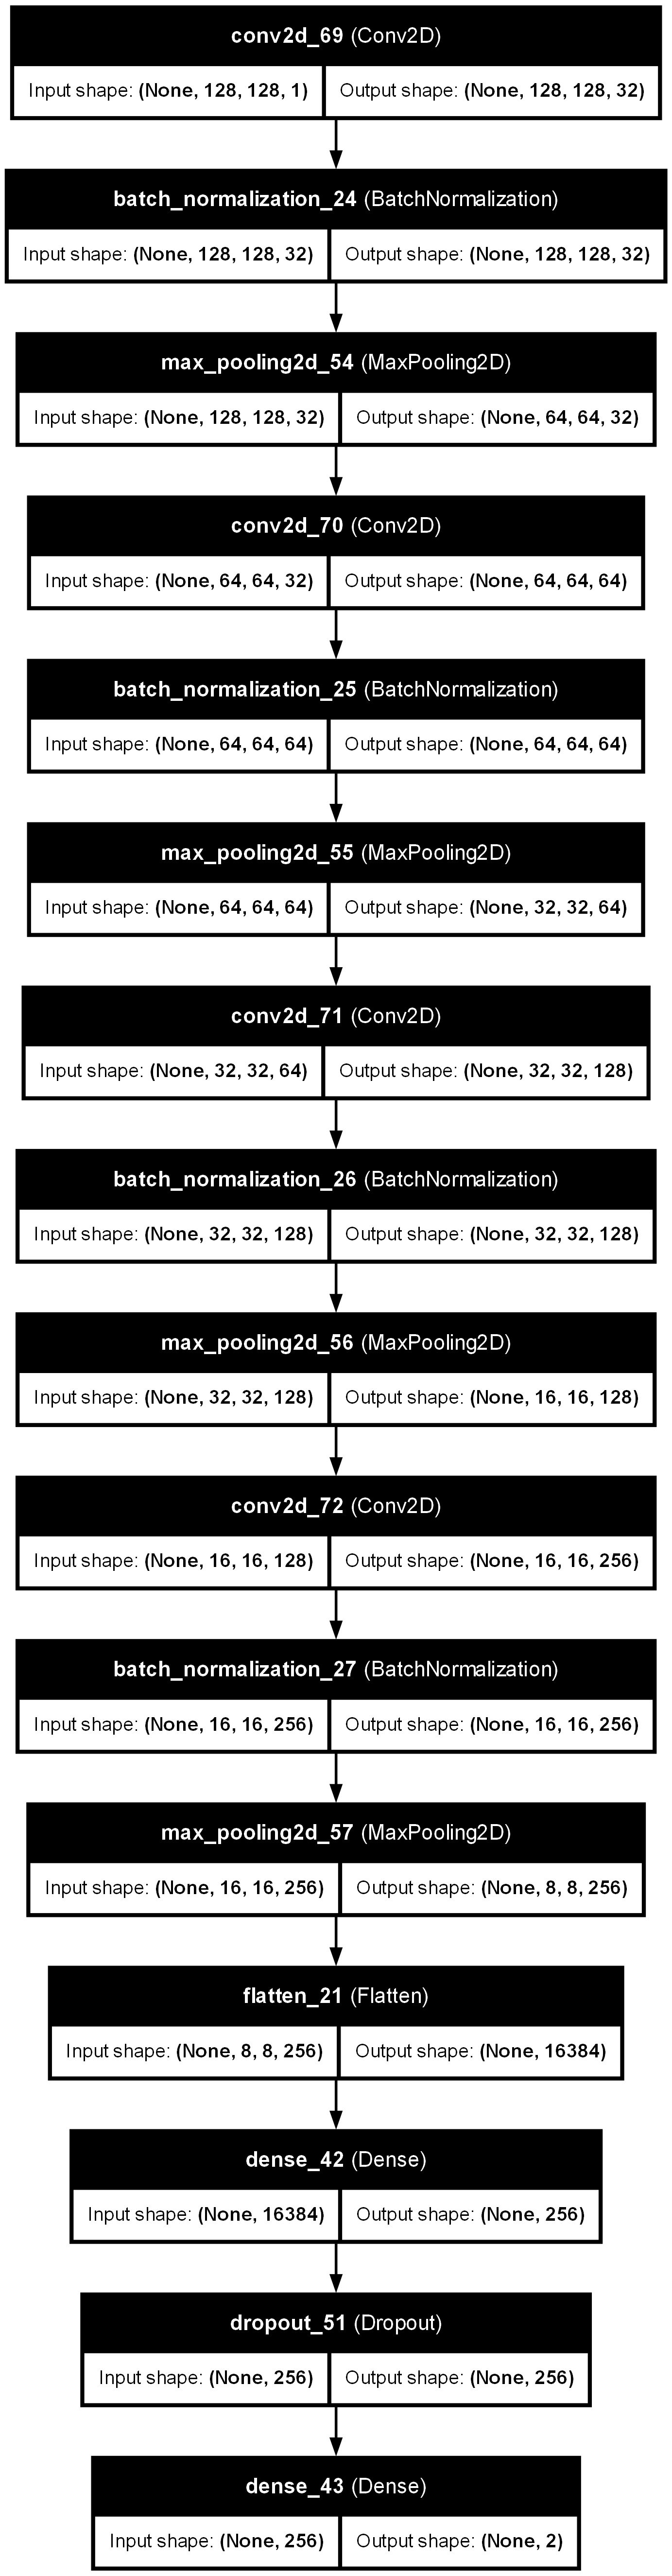

In [107]:
#!!!! You need to install GraohViz and set path variable for this to work: https://graphviz.org/download/
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model

# Assuming 'model' is already created and compiled
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)